Importing needed libraries.

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import cv2
import os
from pathlib import Path

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from tqdm.auto import tqdm
import shutil as sh
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

# import data augmentation
import albumentations as albu

Mounting my drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzipping the images folder.

In [ ]:
!unzip '/content/drive/MyDrive/image_data.zip'

Reading the training CSV file.

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')

Reading the images folder.

In [ ]:
previous_directory = os.getcwd()
%cd /content/image_data

image_folder = '/content/image_data'
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

/content/image_data


In [ ]:
from PIL import Image
import numpy as np

images = []
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path)
    img_array = np.array(img)
    images.append(img_array)


In [ ]:
print('Total Number of images is {}'.format(len(images)))

Total Number of images is 8196


In [ ]:
%cd {previous_directory}

/content


In [ ]:
print('Number of images in train data are {}'.format(train.shape[0]))
train.head()

Number of images in train data are 5733


,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


Reading the bounding boxes for faces CSV file.

In [ ]:
bbox=pd.read_csv('/content/drive/MyDrive/bbox_train.csv')
bbox.head()

,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


These above are the box dimensions around the faces.

Merging all train images with the bounding boxes dataframe.

In [ ]:
train_images = train.merge(bbox, on='Name', how='left')

In [ ]:
print(train_images.isnull().sum())
print(train_images.shape)
train_images

Name         0
HeadCount    0
width        0
height       0
xmin         0
ymin         0
xmax         0
ymax         0
dtype: int64
(24533, 8)


,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202
...,...,...,...,...,...,...,...,...
24528,18205.jpg,8,612,425,9,52,52,116
24529,18207.jpg,4,475,612,160,149,241,226
24530,18207.jpg,4,475,612,226,47,277,104
24531,18207.jpg,4,475,612,113,41,179,106


Histogram visualization for number of faces in each image.

In [ ]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)

    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left,
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(height = 400, width = 600,
          title = title,
          x_axis_label = 'Faces in image',
          y_axis_label = "Count")
    plot.quad(bottom = 0, top = column,left = "left",
        right = "right", source = src, fill_color = colors[0],
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])

    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)

    output_notebook()
    show(plot)

In [ ]:
hist_hover(train_images, 'HeadCount', title='Number of faces per image')

In [ ]:
df=train_images
df.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


Setting up the annotations of the images using the bounding boxes and saving them in a txt file so it can be read on Roboflow.

In [ ]:
# YOLO output folder for saving bounding box annotations
output_folder_yolo = Path("/content/drive/MyDrive/anno")
output_folder_yolo.mkdir(parents=True, exist_ok=True)

# Creating a dictionary to map class names to integers
class_mapping = {'person': 0}

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Create a YOLO annotation file
    annotation_path = output_folder_yolo / f"{row['Name'].replace('.jpg', '.txt')}"

    # Extract coordinates from the DataFrame
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    # Convert coordinates to YOLO format (normalized)
    width, height = int(row['width']), int(row['height'])
    x_center = (xmin + xmax) / (2 * width)
    y_center = (ymin + ymax) / (2 * height)
    box_width = (xmax - xmin) / width
    box_height = (ymax - ymin) / height

    # Get the class label (assuming 'person' as the class)
    class_label = class_mapping.get('person', 0)

    # Write the YOLO annotation to the file
    with open(annotation_path, 'a') as f:
        f.write(f"{class_label} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

Before traing using YOLOV8 , Roboflow framework was used to label the images using the annotations txt file and splitting the images into (train/valid/test) sets then exporting the needed files for training.

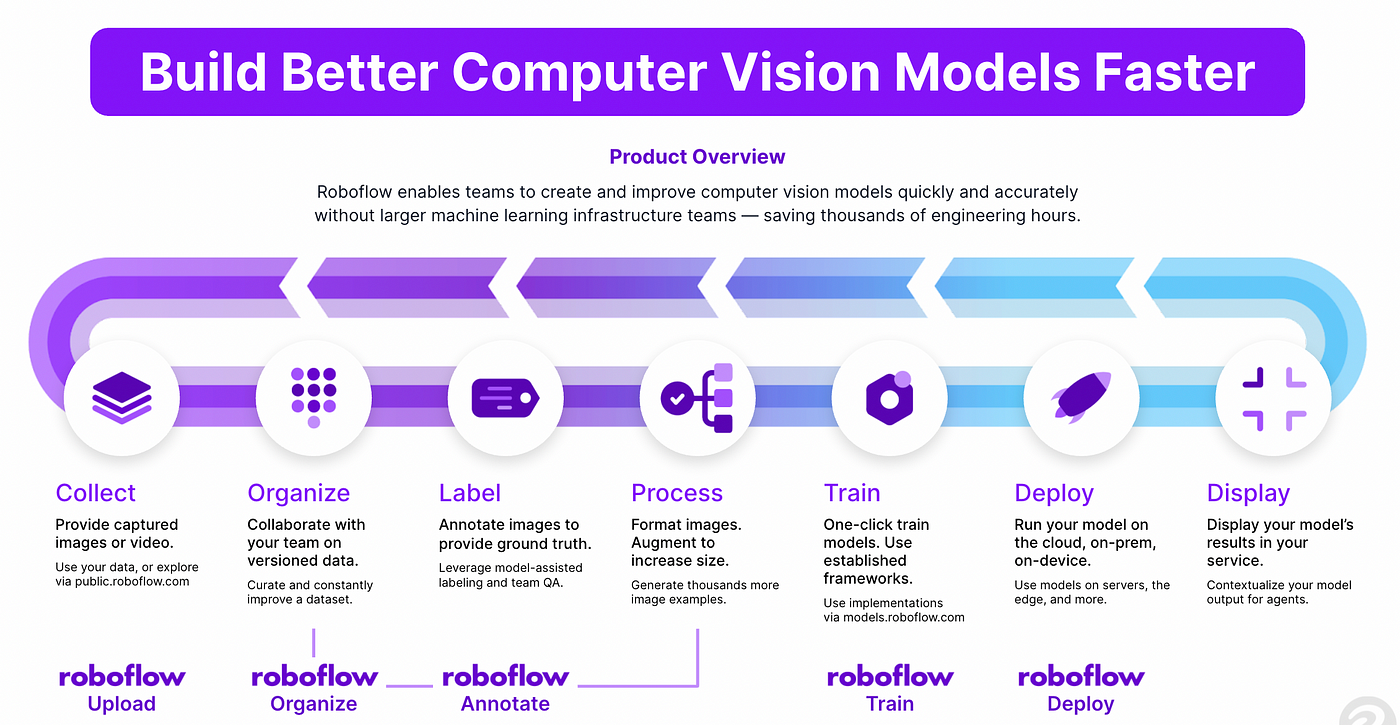

Importing needed libraries for training.

In [ ]:
!nvidia-smi
HOME = os.getcwd()
print(HOME)
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


Importing the project from Roboflow.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="2K2nTnXRl3ElcJFwZMD5")
project = rf.workspace("khg").project("human-detection-na0pn")
dataset = project.version(1).download("yolov8")

Training using YOLOv8s.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=200  imgsz=640 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 227MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Human-detection-1/data.yaml, epochs=200, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, kera

In [ ]:
!ls {HOME}/runs/detect/train3/

args.yaml					     results.csv	  train_batch2.jpg
confusion_matrix.png				     results.png	  val_batch0_labels.jpg
events.out.tfevents.1700723337.d43d350debfc.10222.0  train_batch0.jpg	  val_batch0_pred.jpg
F1_curve.png					     train_batch1.jpg	  val_batch1_labels.jpg
P_curve.png					     train_batch2850.jpg  val_batch1_pred.jpg
PR_curve.png					     train_batch2851.jpg  weights
R_curve.png					     train_batch2852.jpg


/content


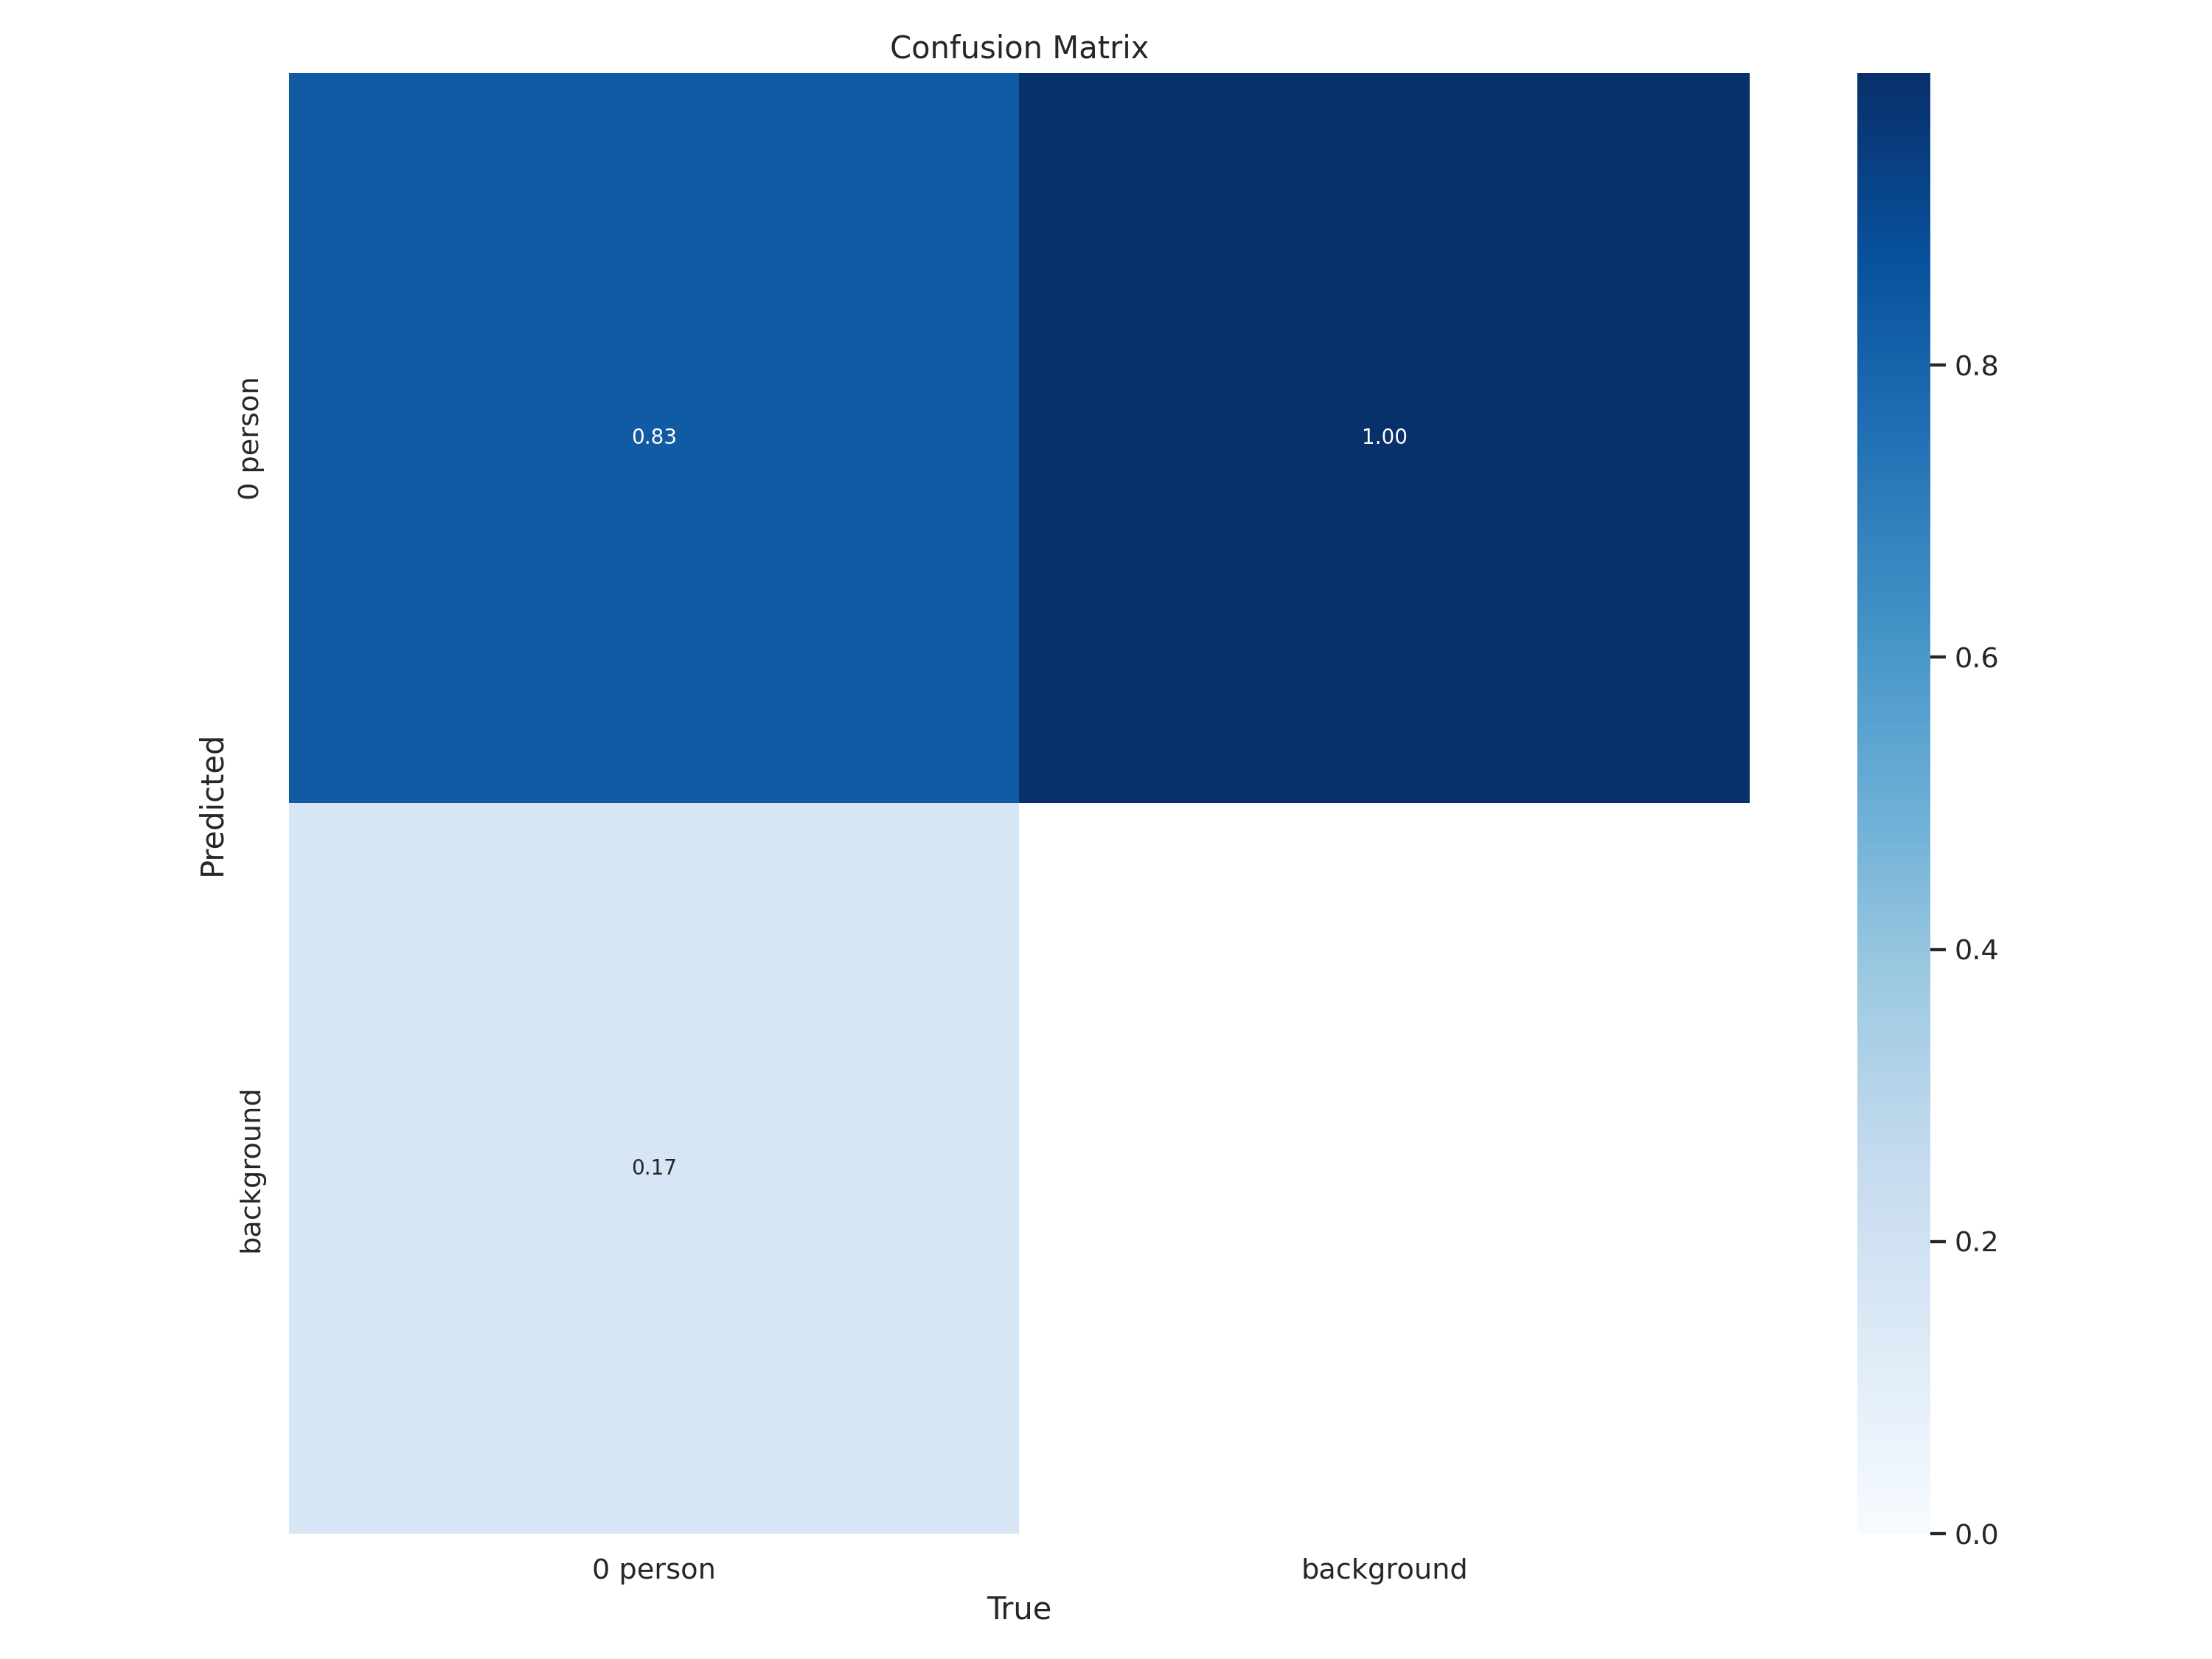

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=1000)

/content


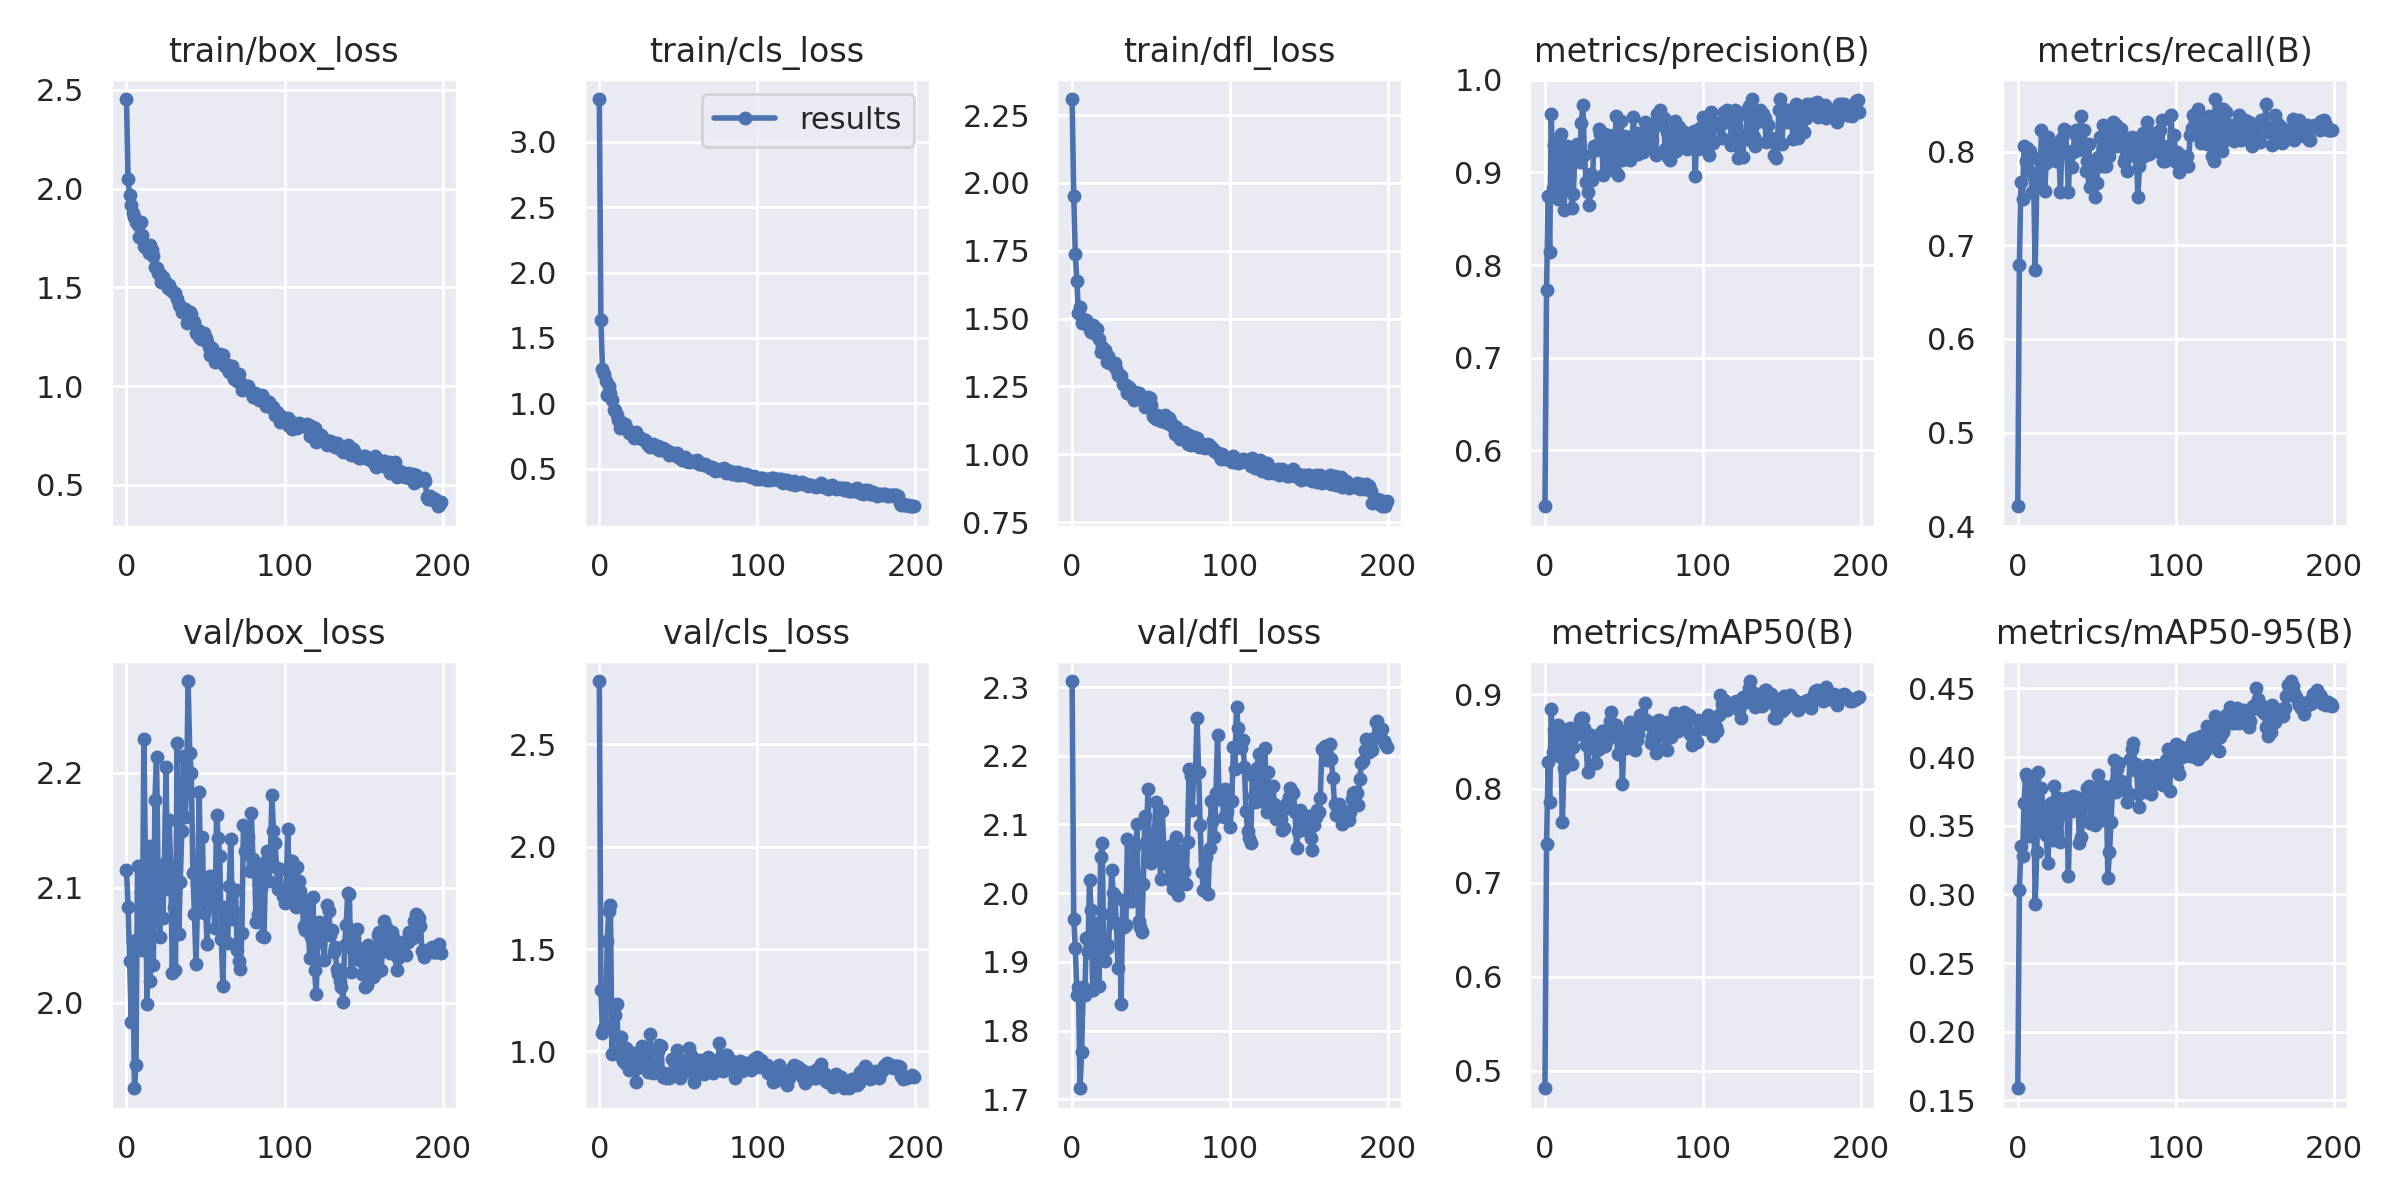

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=1300)

In [ ]:
qw=pd.read_csv('/content/runs/detect/train3/results.csv')
qw[['      metrics/recall(B)','   metrics/precision(B)']]

In [ ]:
#calculating accuracy according to the following equation:

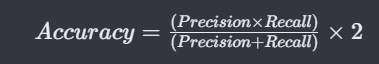

In [ ]:
acc=((0.965*0.8232)/(0.965+0.8232))*2
print("Accuracy: "+ str(acc))

/content


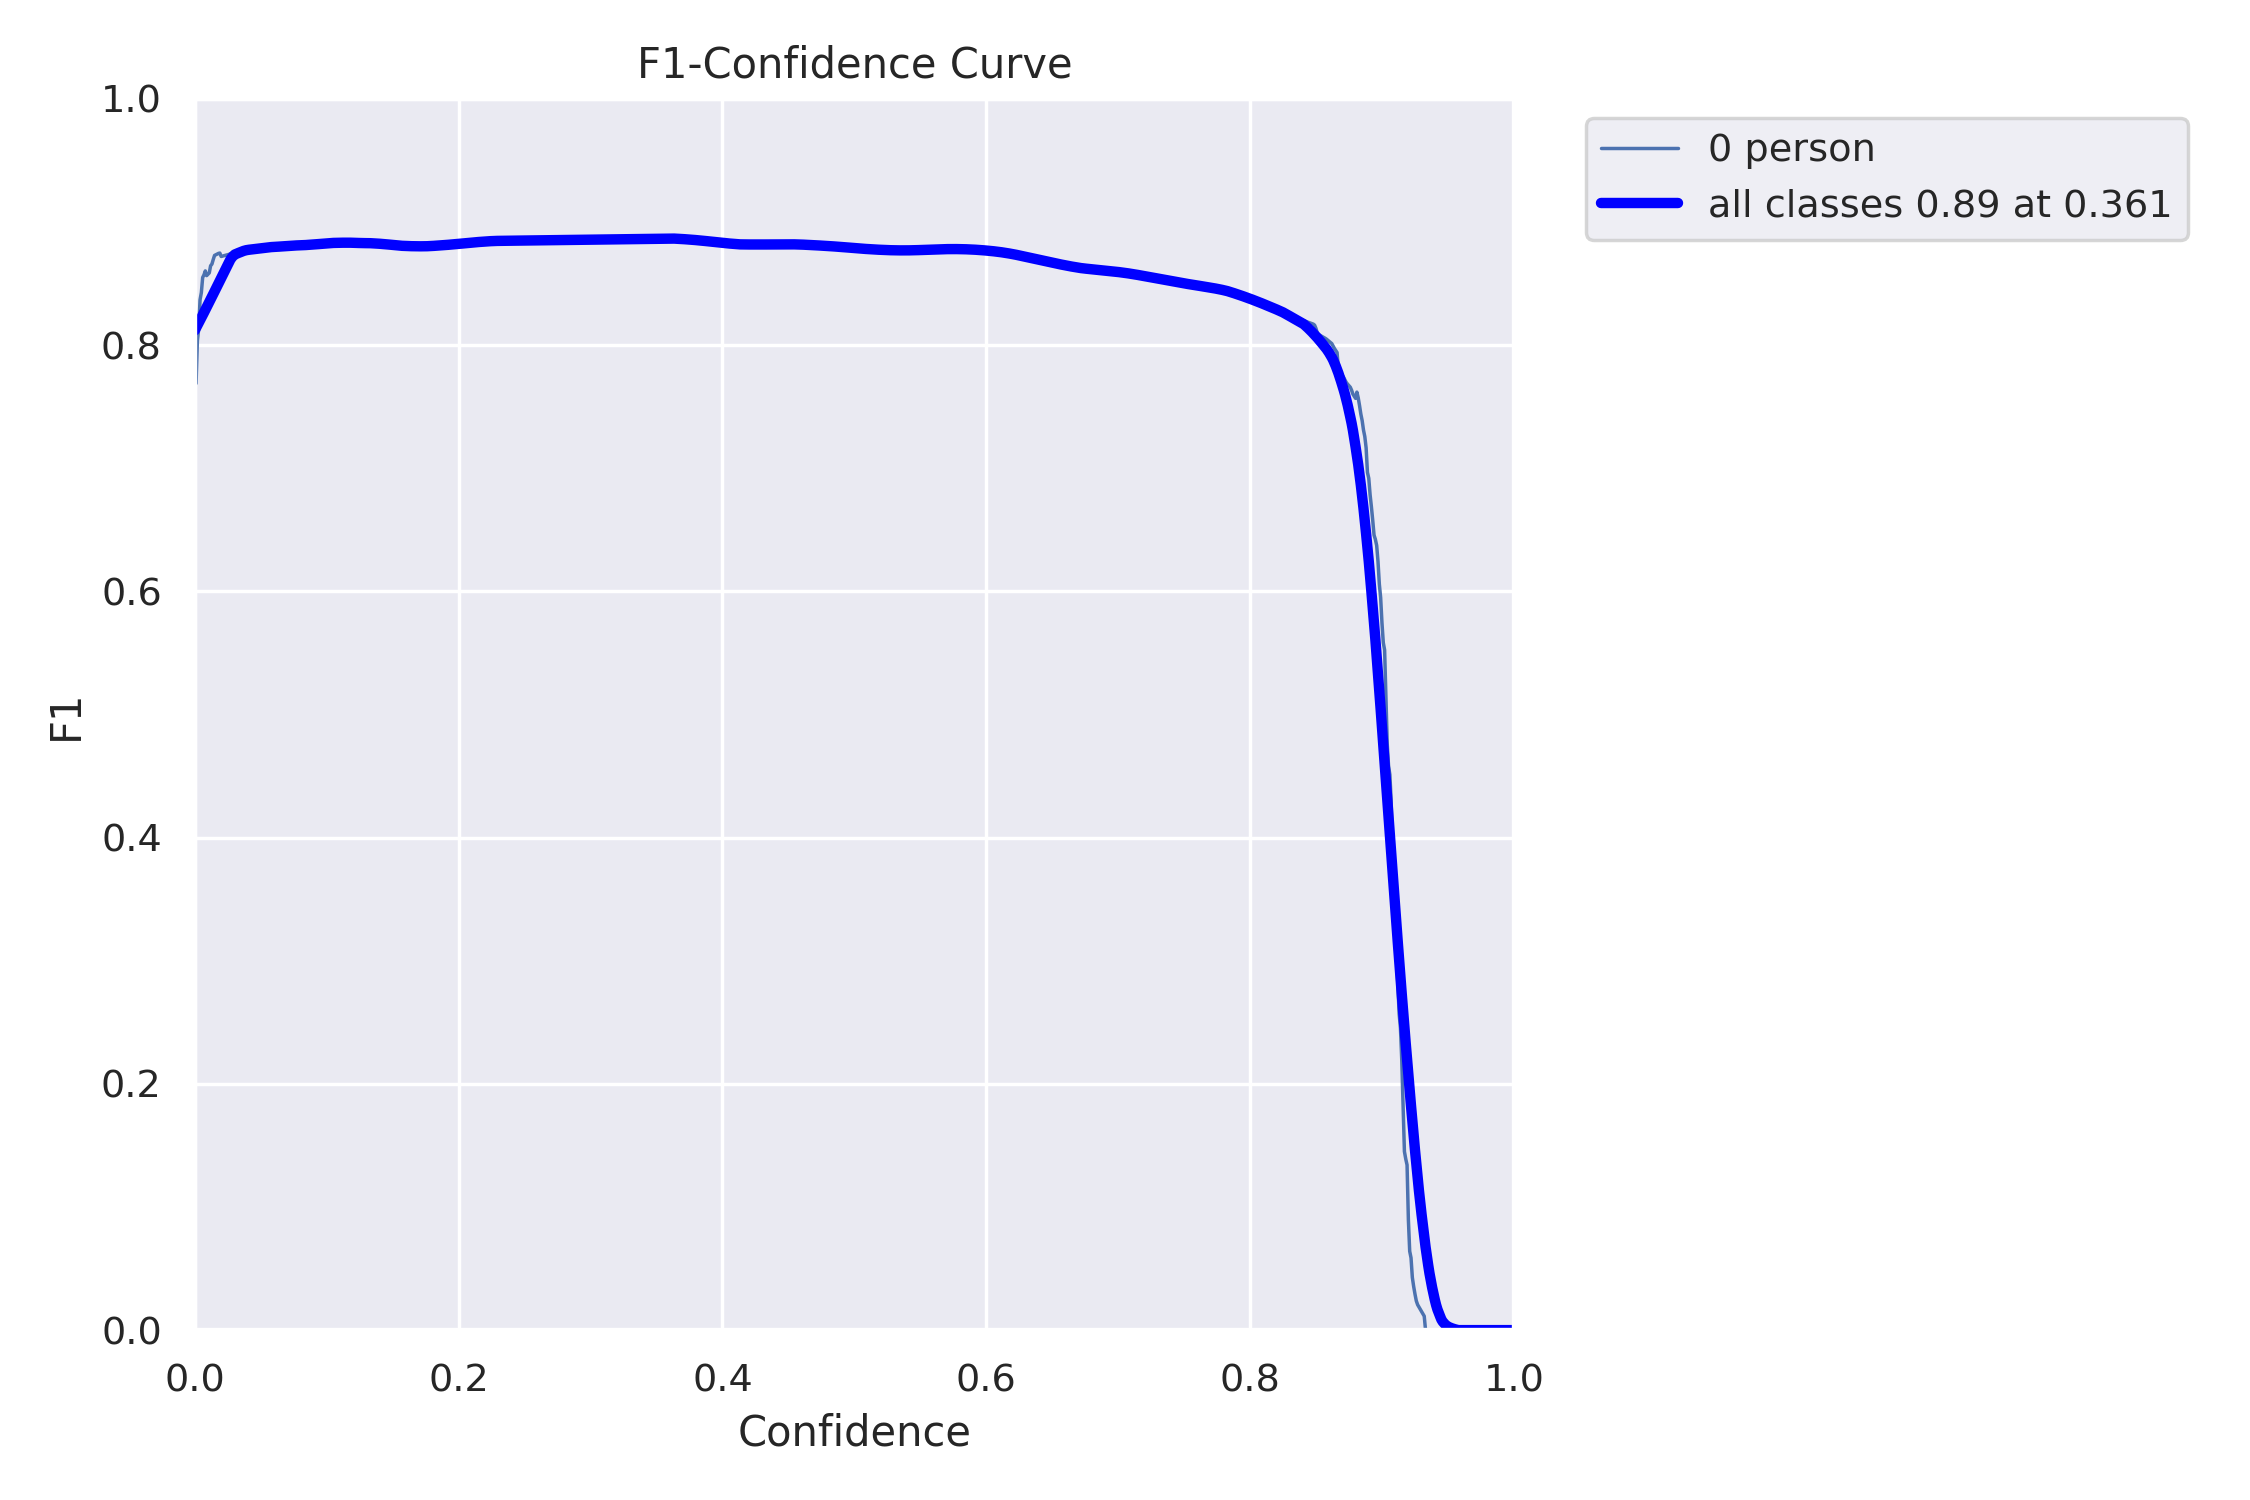

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/F1_curve.png', width=1000)

/content


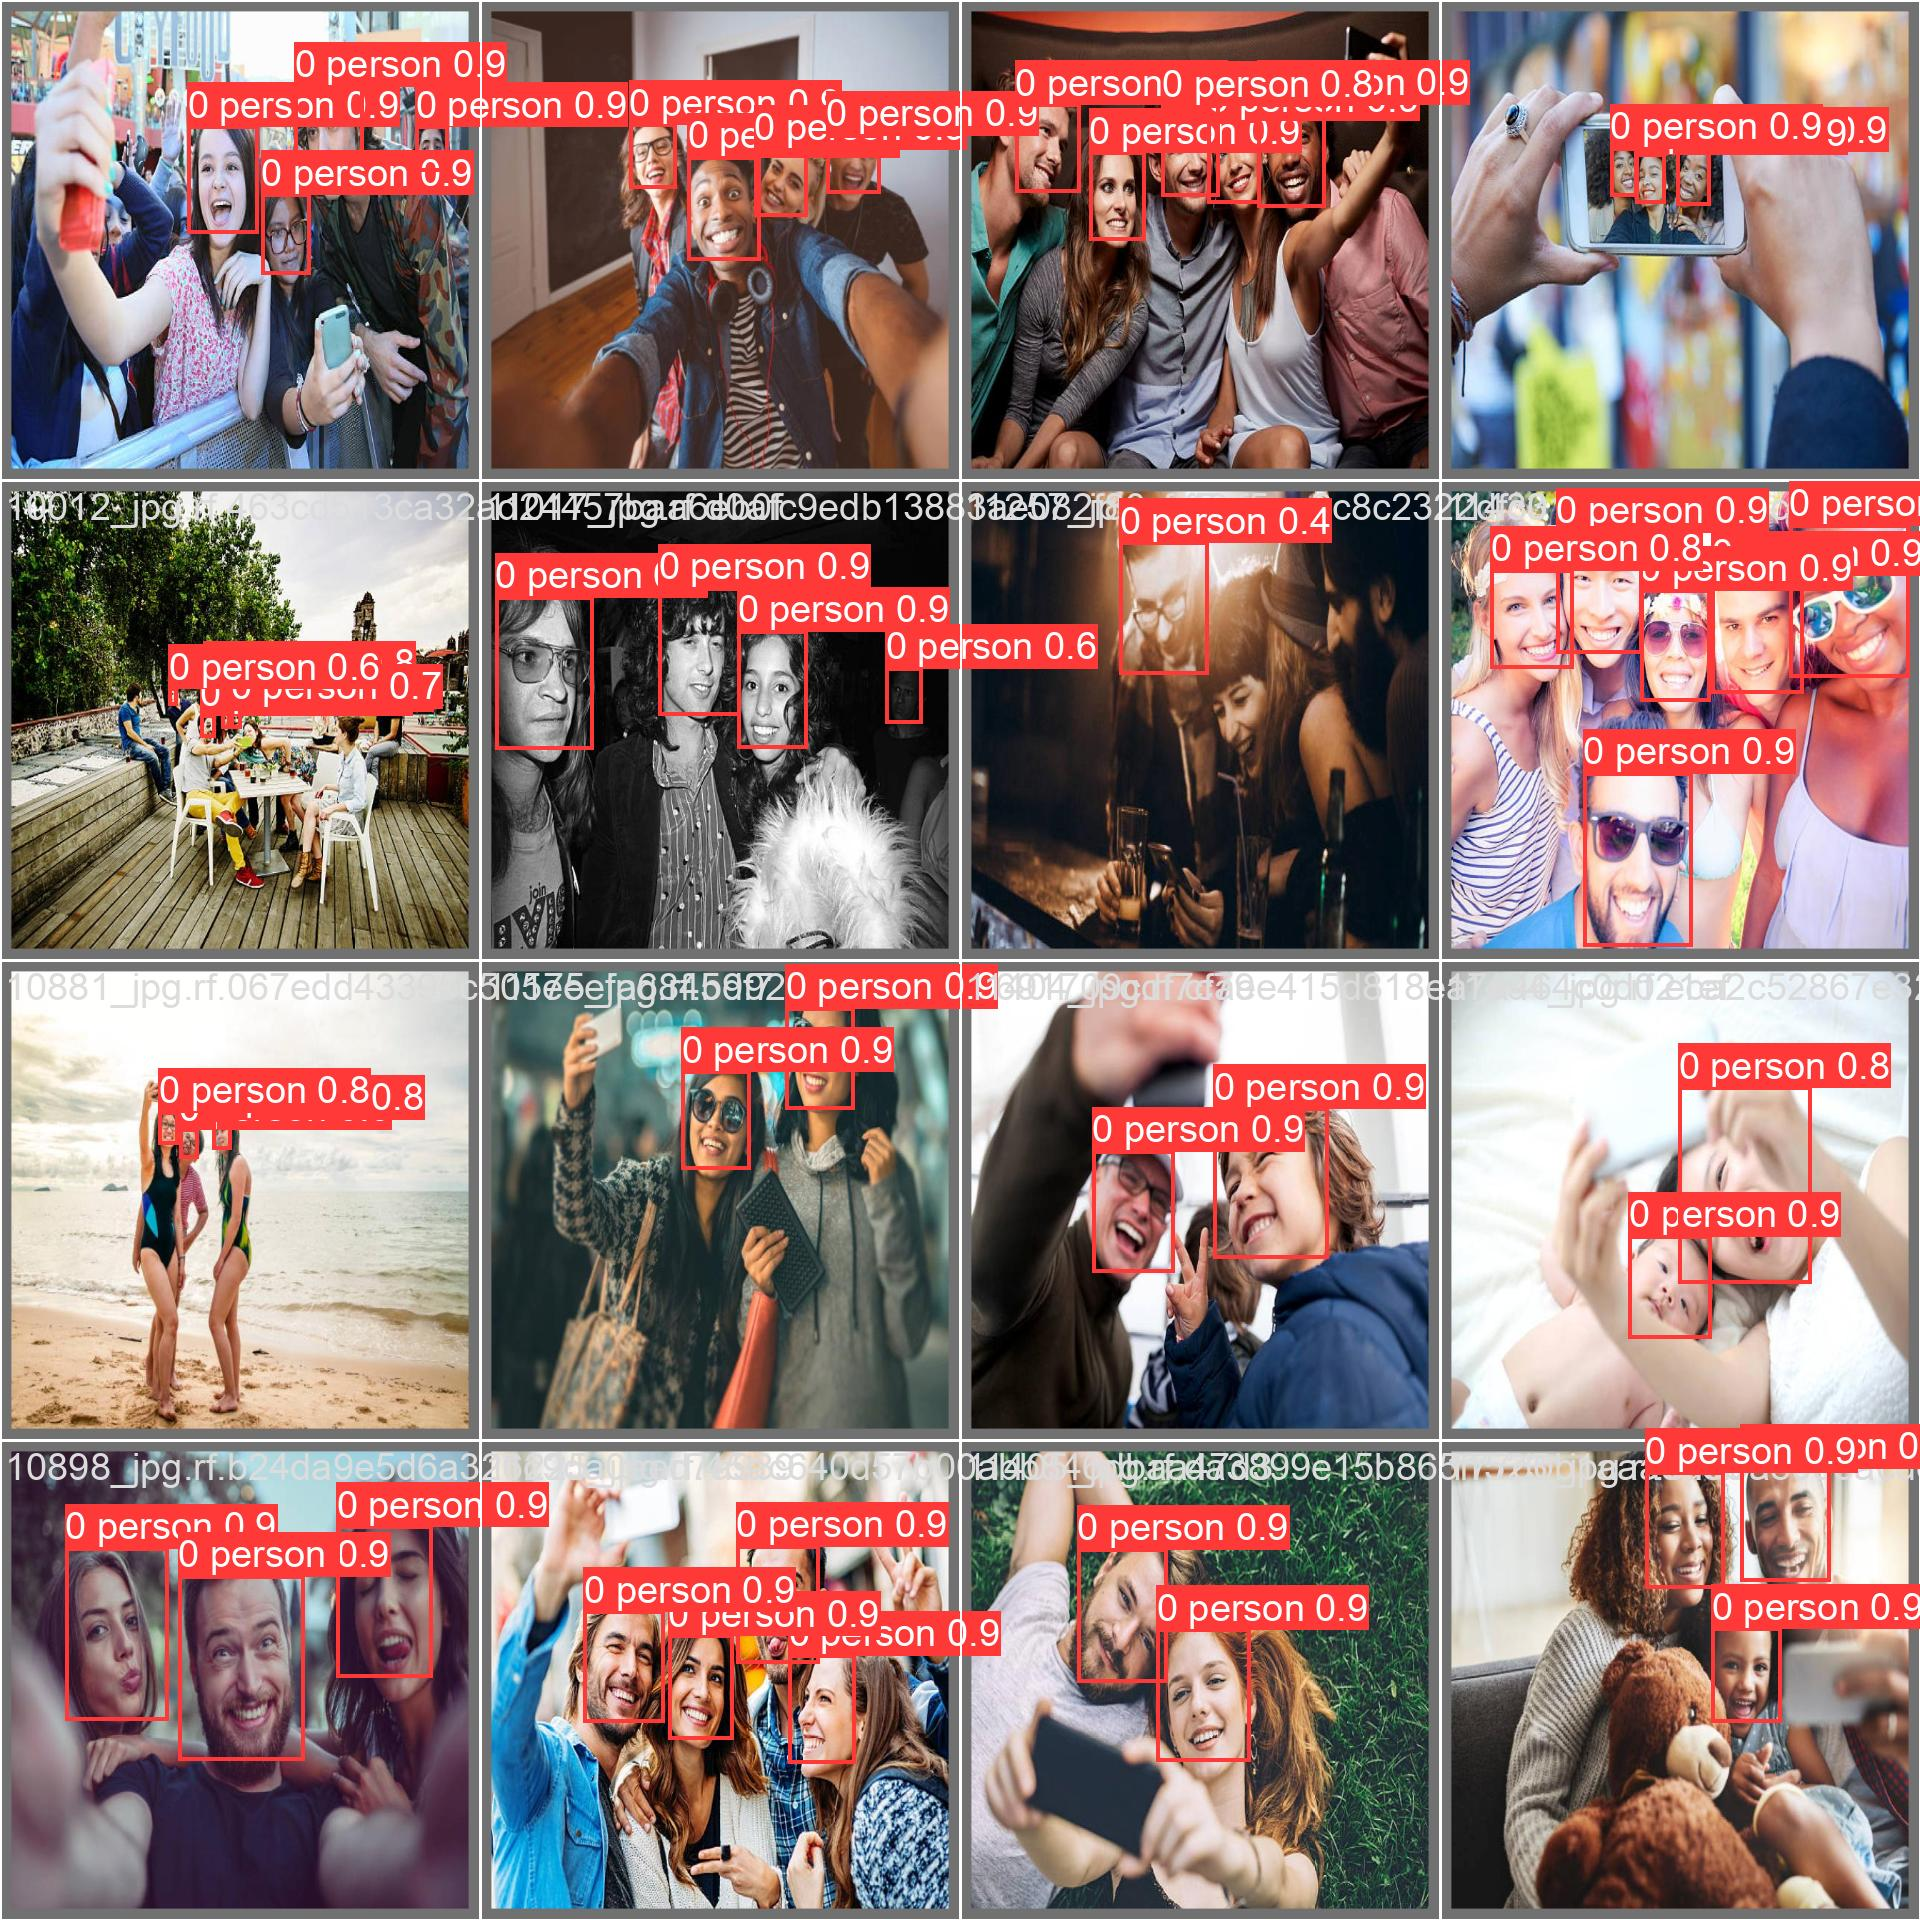

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=1000)

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train3/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:15]:
      display(Image(filename=image_path, width=600))
      print("\n")